# High Impact Goal Calculation Work Book
- Identify goals scored by each team that I can classify as "High Impact"
- High Impact goals are ones scored in the first and final 2 minutes of any period OR Scored within a minute or two of a previous goal
- Create tally table of each of these goal types by team for vizualization

In [421]:
# Dependencies

# Basics
import os
import sys
import time
import sqlite3
import pandas as pd
from collections import defaultdict

# Image Handling
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import seaborn as sns


## Load The Exo 2 font in case of problems with the font
font_path = 'C:/Windows/Fonts/Exo 2.tff'
locations =['../data/Exo_2'] # Font Location

font_files = font_manager.findSystemFonts(fontpaths=locations)

for file in font_files:
    font_manager.fontManager.addfont(file)

    ## Set the date to appear on the source area of plots (the last date of the data)
last_game_date = '2025-01-05'

## File Paths
folder_prefix = ''
# folder_prefix = '..'
data_folder = os.path.join(folder_prefix, '..', 'data/') # Data Folder Path
temp_folder = os.path.join(folder_prefix,'..', 'TEMP/',) # Temp Folder Path
TEMP_FOLDER = temp_folder # Temp Folder Path as used in legacy code
output_folder = os.path.join(temp_folder, 'high_impact_plots/') # Output Folder Path
# data\db\2024_Dec_10_CLEANED_OLD_METHOD.db
db_path = os.path.join(data_folder, 'db', '2025_Jan_07_test2_ROUGH.db') # Database Path
# db_path = os.path.join(data_folder, 'db', '2024_Dec_03_v4_ROUGH.db') # Database Path
# db_path = os.path.join(temp_folder, '2024_Dec_03_v3_ROUGH.db') # Database Path
image_folder = os.path.join(folder_prefix, '..', 'images/') # Image Folder Path
logo_folder = os.path.join(folder_prefix, image_folder, 'logos/') # Logo Folder Path
conference_logo_folder = os.path.join(folder_prefix, logo_folder, 'conference') # Conference Logo Folder Path
export_folder = os.path.join(folder_prefix, image_folder, 'export/') # Export Folder Path
background_folder = os.path.join(folder_prefix, image_folder, 'background/') # Background Folder Path

# Other paths
school_info_path = os.path.join(data_folder, 'arena_school_info.csv') # School Info Path



### Load the Database and Helper Functions

In [422]:
## Load the database
conn = sqlite3.connect(db_path, isolation_level=None)

# convert string time to continuous time
## SQL query to fetch
def extract_goal_summary(conn):
    """
    Extracts and preprocesses the goal summary data from the database.
    """
    query = """
        WITH UniqueGoals AS (
        SELECT DISTINCT Game_ID, Team, Period, Time, PP
        FROM scoring_summary
    )
    SELECT * FROM UniqueGoals;
    """
    goal_df = pd.read_sql(query, conn)
    return goal_df

# Convert string time to continuous time
def convert_to_continuous_time(row):
    """
    Converts period-based time to a continuous format (0-65 minutes).
    """
    period_offsets = {'1st Period': 0, '2nd Period': 20, '3rd Period': 40, 'Overtime': 60}
    minutes, seconds = map(int, row['Time'].split(':'))
    offset = period_offsets.get(row['Period'], 0)
    return offset + minutes + seconds / 60.0

## Load the data
goal_data = extract_goal_summary(conn)
# Create a continuous time column
goal_data['Cont_Time'] = goal_data.apply(convert_to_continuous_time, axis=1)

## Identify Empty Net Goals (EN in the PP column) and flag in a new column
goal_data['EN'] = goal_data['PP'].apply(lambda x: 'EN' in x)

goal_data.head()


,Game_ID,Team,Period,Time,PP,Cont_Time,EN
0,2024-10-04-Michigan State-Lake Superior,Michigan State,1st Period,13:57,,13.950000,False
1,2024-10-04-Michigan State-Lake Superior,Lake Superior,1st Period,16:00,,16.000000,False
2,2024-10-04-Michigan State-Lake Superior,Michigan State,Overtime,0:39,3x3,60.650000,False
3,2024-10-04-Minnesota State-Michigan,Michigan,2nd Period,0:33,PP,20.550000,False
4,2024-10-04-Minnesota State-Michigan,Minnesota State,2nd Period,4:25,,24.416667,False


In [423]:

# Define the function for categorizing goal types
def goal_type_first_last(row):
    """
    Categorizes goals as first minute, last minute, or other.
    """
    # Check if the goal is in the first minute
    if (row['Cont_Time'] < 1 or  # Before the end of the first minute of the game
        (row['Cont_Time'] > 20 and row['Cont_Time'] < 21) or  # Between 20:00 and 21:00 (1st period)
        (row['Cont_Time'] > 40 and row['Cont_Time'] < 41) or  # Between 40:00 and 41:00 (2nd period)
        (row['Cont_Time'] > 60 and row['Cont_Time'] < 61)):  # Between 60:00 and 61:00 (3rd period)
        return 'First Minute'

    # Check if the goal is in the last minute of a period
    elif (row['Cont_Time'] > 19 and row['Cont_Time'] < 20 or  # Between 19:00 and 20:00 (1st period)
          (row['Cont_Time'] > 39 and row['Cont_Time'] < 40) or  # Between 39:00 and 40:00 (2nd period)
          (row['Cont_Time'] > 59 and row['Cont_Time'] < 60) or  # Between 59:00 and 60:00 (3rd period)
          (row['Cont_Time'] > 64 and row['Cont_Time'] < 65)):  # Between 64:00 and 65:00 (overtime)
        return 'Last Minute'

    # Otherwise, categorize as 'Other'
    else:
        return 'Other'

## Do the Same thing to flag the goals that happened in the first and last 2 minutes of the period
def goal_type_first2_last_2(row):
    """
    Flag the goals that happened in the first and last 2 minutes of the period
    """

    if (row['Cont_Time'] < 2 or  # Before the end of the first minute of the game
        (row['Cont_Time'] > 20 and row['Cont_Time'] < 22) or  # Between 20:00 and 21:00 (1st period)
        (row['Cont_Time'] > 40 and row['Cont_Time'] < 42) or  # Between 40:00 and 41:00 (2nd period)
        (row['Cont_Time'] > 60 and row['Cont_Time'] < 62)):  # Between 60:00 and 61:00 (3rd period)
        return 'First 2 Minutes'

    # Check if the goal is in the last 2 minutes of a period
    elif (row['Cont_Time'] > 18 and row['Cont_Time'] < 20 or  # Between 18:00 and 20:00 (1st period)
          (row['Cont_Time'] > 38 and row['Cont_Time'] < 40) or  # Between 38:00 and 40:00 (2nd period)
          (row['Cont_Time'] > 58 and row['Cont_Time'] < 60) or  # Between 58:00 and 60:00 (3rd period)
          (row['Cont_Time'] > 63 and row['Cont_Time'] < 65)):  # Between 63:00 and 65:00 (overtime)
        return 'Last 2 Minutes'
    else:
        return 'Other'


# Create a new column for the goal type
goal_data['Goal_Type'] = goal_data.apply(goal_type_first_last, axis=1)

# Create a new column to flag the goals that happened in the first and last 2 minutes of the period
goal_data['Goal_Type_2'] = goal_data.apply(goal_type_first2_last_2, axis=1)

# Check if The EN goals are in the last minute and flag them as such in new column
goal_data['EN_Last_Minute'] = (goal_data['EN'] & (goal_data['Goal_Type'] == 'Last Minute'))
# DO the same for the last 2 minutes
goal_data['EN_Last_2_Minutes'] = (goal_data['EN'] & (goal_data['Goal_Type_2'] == 'Last 2 Minutes'))

goal_data.head()

,Game_ID,Team,Period,Time,PP,Cont_Time,EN,Goal_Type,Goal_Type_2,EN_Last_Minute,EN_Last_2_Minutes
0,2024-10-04-Michigan State-Lake Superior,Michigan State,1st Period,13:57,,13.950000,False,Other,Other,False,False
1,2024-10-04-Michigan State-Lake Superior,Lake Superior,1st Period,16:00,,16.000000,False,Other,Other,False,False
2,2024-10-04-Michigan State-Lake Superior,Michigan State,Overtime,0:39,3x3,60.650000,False,First Minute,First 2 Minutes,False,False
3,2024-10-04-Minnesota State-Michigan,Michigan,2nd Period,0:33,PP,20.550000,False,First Minute,First 2 Minutes,False,False
4,2024-10-04-Minnesota State-Michigan,Minnesota State,2nd Period,4:25,,24.416667,False,Other,Other,False,False


### Count High Impact Goals (Goals scored within a minute or 2 of another goal being scored)

In [424]:
# Sort the data by Game_ID and Cont_Time for chronological processing
goal_data_sorted = goal_data.sort_values(by=['Game_ID', 'Cont_Time']).reset_index(drop=True)

# Display the sorted data to verify
goal_data_sorted.head()

# Group data by Game_ID to analyze each game separately
grouped = goal_data_sorted.groupby('Game_ID')


# Debugging the logic and fixing the issue
# Reinitialize dictionaries to track counts
team_quick_responses = defaultdict(int)
opponent_quick_responses = defaultdict(int)

# Process each game individually again
for game_id, game_data in grouped:
    # Reset index for easier row iteration
    game_data = game_data.reset_index(drop=True)
    
    # Iterate through goals in this game
    for i in range(len(game_data)):
        current_team = game_data.loc[i, 'Team']
        current_time = game_data.loc[i, 'Cont_Time']
        
        # Compare with subsequent goals in the same game
        for j in range(i + 1, len(game_data)):
            next_team = game_data.loc[j, 'Team']
            next_time = game_data.loc[j, 'Cont_Time']
            
            # If the time difference is more than 1 minute, stop checking
            if next_time - current_time > 1:
                break
            
            # If the same team scores again within 1 minute
            if next_team == current_team:
                team_quick_responses[current_team] += 1
            
            # If the opposing team scores within 1 minute
            elif next_team != current_team:
                opponent_quick_responses[current_team] += 1

# Create the results DataFrame with updated column labels
quick_responses_df = pd.DataFrame({
    'Team': list(set(goal_data_sorted['Team'])),
    'HI_Back_to_Back': [team_quick_responses[team] for team in set(goal_data_sorted['Team'])],
    'HI_Quick_Response': [opponent_quick_responses[team] for team in set(goal_data_sorted['Team'])]
})

# Reinitialize dictionaries to track the new counts for goals within 2 minutes
team_quick_responses_2 = defaultdict(int)
opponent_quick_responses_2 = defaultdict(int)

# Process each game again for the new 2-minute interval logic
for game_id, game_data in grouped:
    # Reset index for easier row iteration
    game_data = game_data.reset_index(drop=True)
    
    # Iterate through goals in this game
    for i in range(len(game_data)):
        current_team = game_data.loc[i, 'Team']
        current_time = game_data.loc[i, 'Cont_Time']
        
        # Compare with subsequent goals in the same game
        for j in range(i + 1, len(game_data)):
            next_team = game_data.loc[j, 'Team']
            next_time = game_data.loc[j, 'Cont_Time']
            
            # If the time difference is more than 2 minutes, stop checking for 2-minute responses
            if next_time - current_time > 2:
                break
            
            # If the same team scores again within 2 minutes
            if next_team == current_team:
                team_quick_responses_2[current_team] += 1
            
            # If the opposing team scores within 2 minutes
            elif next_team != current_team:
                opponent_quick_responses_2[current_team] += 1

# Add the new columns to the results DataFrame
quick_responses_df['HI_Back_to_Back_2'] = [
    team_quick_responses_2[team] for team in set(goal_data_sorted['Team'])
]
quick_responses_df['HI_Quick_Response_2'] = [
    opponent_quick_responses_2[team] for team in set(goal_data_sorted['Team'])
]

# Display the updated results
quick_responses_df.head()


,Team,HI_Back_to_Back,HI_Quick_Response,HI_Back_to_Back_2,HI_Quick_Response_2
0,Michigan State,3,0,8,2
1,Providence,0,2,2,4
2,Vermont,4,2,4,7
3,American Intl,2,1,4,1
4,Bemidji State,3,5,4,9


### Tally The Goal Types into a Team Table

In [425]:
def enforce_column_presence(goal_tally, columns):
    """
    Ensure that all required columns are present in the goal tally DataFrame.
    If a column is missing, add it and fill with zeros.
    """
    for col in columns:
        if col not in goal_tally.columns:
            goal_tally[col] = 0
    return goal_tally

def robust_final_tally(goal_data):
    """
    Tally the number of goals by team, ensuring all expected columns are enforced explicitly.
    """
    # Define expected columns for each group type
    expected_columns_type = ['First Minute', 'Last Minute', 'Other']
    expected_columns_type2 = ['First 2 Minutes', 'Last 2 Minutes']

    # Group and tally goals by Goal_Type
    goal_tally_type = goal_data.groupby(['Team', 'Goal_Type']).size().unstack(fill_value=0).reset_index()

    # Ensure all expected columns are present for Goal_Type
    goal_tally_type = enforce_column_presence(goal_tally_type, expected_columns_type)

    # Group and tally goals by Goal_Type_2
    goal_tally_type2 = goal_data.groupby(['Team', 'Goal_Type_2']).size().unstack(fill_value=0).reset_index()

    # Ensure all expected columns are present for Goal_Type_2
    goal_tally_type2 = enforce_column_presence(goal_tally_type2, expected_columns_type2)

    # Merge both grouped DataFrames
    goal_tally = pd.merge(goal_tally_type, goal_tally_type2, on='Team', how='outer').fillna(0)

    # Ensure all columns in the final DataFrame
    all_expected_columns = ['Team'] + expected_columns_type + expected_columns_type2
    goal_tally = enforce_column_presence(goal_tally, all_expected_columns)

    # Calculate total goals
    goal_tally['Total Goals'] = (goal_tally['First Minute'] +
                                 
                                 goal_tally['Last Minute'] +
                                 
                                 goal_tally['Other_x'])

    # Calculate percentages
    goal_tally['Pct First Minute'] = goal_tally['First Minute'] / goal_tally['Total Goals'].replace(0, 1)
    goal_tally['Pct First 2 Minutes'] = goal_tally['First 2 Minutes'] / goal_tally['Total Goals'].replace(0, 1)
    goal_tally['Pct Last Minute'] = goal_tally['Last Minute'] / goal_tally['Total Goals'].replace(0, 1)
    goal_tally['Pct Last 2 Minutes'] = goal_tally['Last 2 Minutes'] / goal_tally['Total Goals'].replace(0, 1)

    # Tally EN Last Minute and EN Last 2 Minutes
    en_last_minute_tally = goal_data[goal_data['EN_Last_Minute']].groupby('Team').size()
    en_last_2_minute_tally = goal_data[goal_data['EN_Last_2_Minutes']].groupby('Team').size()

    # Add EN tallies to the final DataFrame
    goal_tally['EN Last Minute'] = goal_tally['Team'].map(en_last_minute_tally).fillna(0).astype(int)
    goal_tally['EN Last 2 Minutes'] = goal_tally['Team'].map(en_last_2_minute_tally).fillna(0).astype(int)

    return goal_tally

# Apply the function to the data
team_goal_tally = robust_final_tally(goal_data)

#### Merge the High Impact goal data with the Team Goal Tally

In [426]:
# Merge the High Impact Goal data with the goal tally data
team_goal_tally = pd.merge(team_goal_tally, quick_responses_df, on='Team', how='outer')

# Reorganize the table into the following order
# Team, Total Goals, First minute, Pct First Minute, First 2 Minutes, Pct First 2 Minutes, 
# Last Minute, EN Last Minute, Pct Last Minute, Last 2 Minutes, EN Last 2 Minutes, Pct Last 2 Minutes, HI Back-to-Back, 
# HI Quick Response, HI Back-to-Back 2, HI Quick Response 2

# Define the column order
column_order = ['Team', 'Total Goals', 'First Minute', 'Pct First Minute', 'First 2 Minutes', 'Pct First 2 Minutes',
                'Last Minute', 'EN Last Minute', 'Pct Last Minute', 'Last 2 Minutes', 'EN Last 2 Minutes', 'Pct Last 2 Minutes',
                'HI_Back_to_Back', 'HI_Quick_Response', 'HI_Back_to_Back_2', 'HI_Quick_Response_2']

# Reorder the columns
team_goal_tally = team_goal_tally[column_order]


# Display the final DataFrame
team_goal_tally.head()

,Team,Total Goals,First Minute,Pct First Minute,First 2 Minutes,Pct First 2 Minutes,Last Minute,EN Last Minute,Pct Last Minute,Last 2 Minutes,EN Last 2 Minutes,Pct Last 2 Minutes,HI_Back_to_Back,HI_Quick_Response,HI_Back_to_Back_2,HI_Quick_Response_2
0,Air Force,40,1,0.025000,2,0.050000,5,0,0.125000,9,0,0.225000,1,1,3,4
1,Alaska,41,0,0.000000,2,0.048780,1,0,0.024390,3,0,0.073171,1,0,3,4
2,Alaska Anchorage,52,3,0.057692,4,0.076923,4,1,0.076923,10,3,0.192308,1,2,1,7
3,American Intl,51,0,0.000000,4,0.078431,5,1,0.098039,5,1,0.098039,2,1,4,1
4,Arizona State,58,5,0.086207,6,0.103448,13,3,0.224138,16,4,0.275862,3,2,5,3


## Vizualizations

### Create school logo and color dictionary to use in plotting function

In [427]:
## Load the school info to get hex codes, logo files, and other info
school_info_df = pd.read_csv(school_info_path)


# Remove punctuation from the school names (dashes with spaces, . and ' with nothing)
school_info_df['Team'] = school_info_df['Team'].str.replace('-', ' ')
school_info_df['Team'] = school_info_df['Team'].str.replace('.', '')
school_info_df['Team'] = school_info_df['Team'].str.replace("'", '')
# school_info_df.head() # Check the data

# # Create a color dictionary with just the primary (hex1) and secondary (hex2) colors from the school info
# Team: hex1, hex2
# Drop unused columns
school_color_df = school_info_df[['Team', 'hex1', 'hex2']]
color_mapping = school_color_df.set_index('Team').T.to_dict('list')
# color_mapping # Show dictionary
## MAY NEED TO ADD LEADING/ TRAILING zeros to the hex codes

# Create a dictionary of school logos
# Team: logo + '.png'
# Drop unused columns
school_logo_df = school_info_df[['Team', 'logo_abv']]
school_logo_df['logo_abv'] = school_logo_df['logo_abv'] + '.png'
logo_mapping = school_logo_df.set_index('Team')['logo_abv'].to_dict()
# logo_mapping # Check the dictionary




C:\Users\jbanc\AppData\Local\Temp\ipykernel_21448\2724386260.py:15: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  color_mapping = school_color_df.set_index('Team').T.to_dict('list')
C:\Users\jbanc\AppData\Local\Temp\ipykernel_21448\2724386260.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  school_logo_df['logo_abv'] = school_logo_df['logo_abv'] + '.png'


#### Helper function for Logos and team colors

In [428]:
## Sub function to use withing plotting functions to place logos
def add_logos_to_plot(data_df, x_col, y_col, logo_mapping, logo_folder, ax, teams_in_region):
    # Plot logos for specific teams
    for team in teams_in_region:
        team_data = data_df[data_df['Team'] == team]
        if not team_data.empty:
            x = team_data[x_col].values[0]
            y = team_data[y_col].values[0]
            logo_path = os.path.join(logo_folder, logo_mapping.get(team, ""))
            if logo_path:
                try:
                    logo_img = plt.imread(logo_path)
                    imagebox = OffsetImage(logo_img, zoom=0.15)  # Adjust zoom as needed
                    ab = AnnotationBbox(imagebox, (x, y), frameon=False, xybox=(0, 0), boxcoords="offset points", pad=0)
                    ax.add_artist(ab)  # Apply the ax here as the artist is being added to ax
                except Exception as e:
                    print(f"Error adding logo for {team}: {e}")

In [429]:
## Make sure the color mapping dictionary has valid hex color codes
def clean_color_mapping(color_mapping):
    """
    Cleans and validates color codes in the color_mapping dictionary.
    Ensures all colors are valid hex codes starting with '#'.

    Parameters:
    - color_mapping (dict): A dictionary where the key is the team name and the value is a list of hex colors.

    Returns:
    - cleaned_mapping (dict): A dictionary with properly formatted hex color codes.
    """
    cleaned_mapping = {}
    for team, colors in color_mapping.items():
        cleaned_colors = []
        for color in colors:
            if isinstance(color, str):
                # Ensure it starts with '#' and is a valid hex color code
                color = color.strip()
                if not color.startswith('#'):
                    color = f'#{color}'
                if len(color) == 7 and all(c in '0123456789ABCDEFabcdef' for c in color[1:]):
                    cleaned_colors.append(color)
                else:
                    # Use a fallback color if invalid
                    cleaned_colors.append('#000000')  # Default to black for invalid colors
            else:
                cleaned_colors.append('#000000')  # Default to black for non-string values
        cleaned_mapping[team] = cleaned_colors
    return cleaned_mapping

# Clean and validate the color mapping
color_mapping = clean_color_mapping(color_mapping)

In [430]:
## Make sure the logo mapping dictionary has valid file names and the correct color format
def convert_to_rgba(logo_mapping, logo_folder):
    for team, filename in logo_mapping.items():
        file_path = os.path.join(logo_folder, filename)
        try:
            with Image.open(file_path) as img:
                # Convert the image to RGBA if not already in that mode
                if img.mode != 'RGBA':
                    rgba_image = img.convert('RGBA')
                    # Save the converted image back to the folder
                    rgba_image.save(file_path)
                    print(f"Converted {filename} to RGBA.")
                else:
                    print(f"{filename} is already RGBA.")
        except FileNotFoundError:
            print(f"File {filename} not found in {logo_folder}.")
        except Exception as e:
            print(f"An error occurred with {filename}: {e}")

# Run the conversion function
convert_to_rgba(logo_mapping, logo_folder)

afa.png is already RGBA.
akf.png is already RGBA.
aka.png is already RGBA.
aic.png is already RGBA.
asu.png is already RGBA.
arm.png is already RGBA.
bmj.png is already RGBA.
ben.png is already RGBA.
bc_.png is already RGBA.
bu_.png is already RGBA.
bgs.png is already RGBA.
brn.png is already RGBA.
cns.png is already RGBA.
clk.png is already RGBA.
clg.png is already RGBA.
cc_.png is already RGBA.
_con.png is already RGBA.
cor.png is already RGBA.
dar.png is already RGBA.
den.png is already RGBA.
fsu.png is already RGBA.
har.png is already RGBA.
hcr.png is already RGBA.
lss.png is already RGBA.
liu.png is already RGBA.
uml.png is already RGBA.
uma.png is already RGBA.
mrc.png is already RGBA.
mer.png is already RGBA.
mia.png is already RGBA.
mic.png is already RGBA.
msu.png is already RGBA.
mtu.png is already RGBA.
min.png is already RGBA.
mns.png is already RGBA.
mnd.png is already RGBA.
unh.png is already RGBA.
nia.png is already RGBA.
ndk.png is already RGBA.
noe.png is already RGBA.

## Create the plots

#### Figure and Font Size Settings

In [431]:
### Set Figure Size (Global)
set_fig_size = (10, 10)

### Font Properties
font = "Exo 2"

font_title_param = {'fontname': font, 'fontsize': 24, 'fontweight': 'bold'}
font_label_param = {'fontname': font, 'fontsize': 16, 'fontweight': 'bold'}


#### Create dictionary of team groups 

In [432]:
### In season Tourney Groups
# Create a list with all 65 D1 Teams
all_teams = list(set(goal_data['Team']))
# create logo map for all teams
all_logo_mapping = {team: logo_mapping.get(team, '') for team in all_teams}


# Four Team Group (GLI)
gli_teams = ['Michigan Tech', 'Western Michigan', 'Michigan State', 'Northern Michigan']
gli_logo_mapping = {team: logo_mapping.get(team, '') for team in gli_teams}

# Four Team Group (Beanpot)
beanpot_teams = ['Boston College', 'Boston University', 'Harvard', 'Northeastern']
beanpot_logo_mapping = {team: logo_mapping.get(team, '') for team in beanpot_teams}

# Kwick Trip Faceoff - Wis hosted Dec 28-29
kwik_trip_teams = ["Wisconsin", "Ferris State", "Connecticut", "Alaska"]
kwik_trip_logo_mapping = {team: logo_mapping.get(team, '') for team in kwik_trip_teams}

# Desert Hockey Classic - ASU hosted Jan 3-4
desert_classic_teams = ["Arizona State", "Robert Morris", "Cornell", "Massachusetts" ]
desert_classic_logo_mapping = {team: logo_mapping.get(team, '') for team in desert_classic_teams}

# Auld Lang Syne - Dec 28-29
auld_lang_teams = ["Dartmouth", "Alaska Anchorage", "Northeastern", "Providence"]
auld_lang_logo_mapping = {team: logo_mapping.get(team, '') for team in auld_lang_teams}


### Call the Appropriate Group of teams by uncommenting out the group to plot

# Groups Defined Above to Call
# conference_teams_mens
# 'Atlantic', 'Big Ten', 'CCHA', 'ECAC', 'Hockey East', 'NCHC', 'Independents'

# conference_teams_womens
# 'Atlantic', 'ECAC', 'Hockey East', 'NewHA', 'WCHA'
# 
# plot_group = 'Full 65'
# plot_group = 'Big Ten'  # Set the group to plot
# plot_group = 'Atlantic'  # Set the group to plot
# plot_group = 'CCHA'  # Set the group to plot
# plot_group = 'ECAC'  # Set the group to plot
plot_group = 'Hockey East'  # Set the group to plot
# plot_group = 'NCHC'  # Set the group to plot

# Plot The GLI Teams
# plot_group = 'GLI'  # Set the group to plot
# plot_group = 'Great Lakes Invitational'
# plot_group = 'Beanpot'  # Set the group to plot
# plot_group = 'Test BC'  # Set the group to plot/
# plot_group = 'Kwik Trip'  # Set the group to plot
# plot_group = 'Desert Classic'  # Set the group to plot
# plot_group = 'Auld Lang Syne'  # Set the group to plot
# plot_group = 'Independents'  # Set the group to plot
# plot_group = 'WCHA'  # Set the group to plot

In [433]:
# Define the conferences
conference_teams_mens = {
    'Atlantic': ['Air Force', "American Intl", 'Army', 'Bentley', 'Canisius', 'Holy Cross', 'Mercyhurst', 
                 'Niagara', 'RIT', 'Robert Morris', 'Sacred Heart'],
    'Big Ten': ['Michigan', 'Michigan State', 'Minnesota', 'Notre Dame', 'Ohio State', 'Penn State', 'Wisconsin'],
    'CCHA': ['Augustana', 'Bemidji State', 'Bowling Green', 'Ferris State', 'Lake Superior', 'Michigan Tech', 
             'Minnesota State', 'Northern Michigan', 'St Thomas'],
    'ECAC': ['Brown', 'Clarkson', 'Colgate', 'Cornell', 'Dartmouth', 'Harvard', 'Princeton', 'Quinnipiac',
             'Rensselaer', 'St Lawrence', 'Union', 'Yale'],
    'Hockey East': ['Boston College', 'Boston University', 'Connecticut', 'Maine', 'Massachusetts', 'Mass Lowell',
                    'Merrimack', 'New Hampshire', 'Northeastern', 'Providence', 'Vermont'],
    'NCHC': ['Arizona State', 'Colorado College', 'Denver', 'Miami', 'Minnesota Duluth', 'North Dakota', 'Omaha', 
             'St Cloud State', 'Western Michigan'],
    'Independents': ['Alaska-Anchorage', 'Alaska', 'Lindenwood', 'Long Island', 'Stonehill'],
    'GLI': gli_teams,
    'Beanpot': beanpot_teams,
    'Kwik Trip': kwik_trip_teams,
    'Desert Classic': desert_classic_teams,
    'Auld Lang Syne': auld_lang_teams,
    'Great Lakes Invitational': gli_teams,
    'Full 65': all_teams
    
}

# Load conference logos - Mens
conference_logo_mapping_mens = {
    'Atlantic': 'atlantic.png',
    'Big Ten': 'big_ten.png',
    'CCHA': 'ccha.png',
    'ECAC': 'ecac.png',
    'Hockey East': 'hockey_east.png',
    'NCHC': 'nchc.png',
    'Independents': 'independent_scaled.png'
}

### Conference Membersip - Women's D1
w_atlantic = ['Lindenwood', 'Mercyhurst', 'Penn State', 
            'RIT', 'Robert Morris', 'Syracuse']
w_ecac = ['Brown', 'Clarkson', 'Colgate', 'Cornell', 'Dartmouth', 'Harvard', 'Princeton', 'Quinnipiac',
        'Rensselaer', 'St Lawrence', 'Union', 'Yale']
w_hockey_east = ['Boston College', 'Boston University', 'Connecticut', 'Holy Cross', 
                'Maine', 'Merrimack', 'New Hampshire', 'Northeastern', 'Providence', 'Vermont']
w_newha = ['Assumption', 'Franklin Pierce', 'Long Island', 'Post', 'Sacred Heart',
        'Saint Anselm', 'Saint Michaels', 'Stonehill']
w_wcha = ['Bemidji State', 'Minnesota', 'Minnesota Duluth', 'Minnesota State', 'Ohio State', 
            'St Cloud State', 'St Thomas', 'Wisconsin']

conference_teams_womens = {
    'Atlantic': w_atlantic,
    'ECAC': w_ecac,
    'Hockey East': w_hockey_east,
    'NewHA': w_newha,
    'WCHA': w_wcha
}
conference_logo_mapping_womens = {
    'Atlantic': 'atlantic.png',
    'ECAC': 'ecac.png',
    'Hockey East': 'hockey_east.png',
    'NewHA': 'w_newha.png',
    'WCHA': 'w_wcha.png'
}

In [434]:
# Teams to plot
# Get list from conference dictionary
teams_to_plot = conference_teams_mens[f'{plot_group}'] # Set the group to plot from the Mens Conference Teams
# teams_to_plot = conference_teams_womens[f'{plot_group}'] # Set the group to plot from the Womens Conference Teams

# Set the figure size # Set above next to font settings
# set_fig_size = (10, 10)
# Title of Group
group_title = f'{plot_group}'

#### Set Background Image
path_to_bg_image =  'main1.png' #
alpha_value = 0.1 # Set the transparency of the background image
# Load the background image
bg_img = mpimg.imread(background_folder + path_to_bg_image)
# images\background\main1.png
# bg_img = mpimg.imread('../../images/background/main1.png') # Add '.. string to the path

# Add '.. string to the path
# bg_img = rotate(bg_img, 90) # Rotate the image

#### PLOT: Last Minute and First Minute Goals

In [435]:
## By Goal Count

def create_first_last_goal_plot_1(group_title, teams_to_plot):
    # figure_size = set_fig_size # Unness

    # Calculate average and standard deviation for First Minute Goals and Last Minute Goals
    avg_first_minute = team_goal_tally['First Minute'].mean()
    std_first_minute = team_goal_tally['First Minute'].std()
    avg_last_minute = team_goal_tally['Last Minute'].mean()
    std_last_minute = team_goal_tally['Last Minute'].std()

    # Create the base scatter plot with all teams
    fig, ax = plt.subplots(figsize = set_fig_size)
    sns.scatterplot(data=team_goal_tally, x='First Minute', y='Last Minute', 
        hue='Team', s=100, ax=ax)
    

    # Add Trend Line
    sns.regplot(data=team_goal_tally, x='First Minute', y='Last Minute', 
        scatter=False, ax=ax)

    # Adjust x-axis to add padding on the left
    xmin, xmax = ax.get_xlim()
    new_xmin = xmin  # Subtract 2 from the x-minimum for additional padding
    ax.set_xlim(new_xmin, xmax)

    # Get and Adjust y-limits if needed
    ymin, ymax = ax.get_ylim()


    # Plot the average and standard deviation lines
    plt.axhline(y=avg_last_minute, color='red', linestyle='--', label='Average Last Minute Goals')
    plt.axvline(x=avg_first_minute, color='blue', linestyle='--', label='Average First Minute Goals')
    plt.errorbar(avg_first_minute, avg_last_minute, xerr=std_first_minute, 
        yerr=std_last_minute, fmt='o', color='purple', label='Standard Deviation')    

    # Set the background image (ensure the image is adjusted tot he new x and y limits)
    ax.imshow(bg_img, extent=[new_xmin, xmax, ymin, ymax], aspect='auto', zorder=0, alpha=alpha_value)

    # Add logos for specific teams (the teams_to_plot list)
    add_logos_to_plot(team_goal_tally, 'First Minute', 'Last Minute', logo_mapping, logo_folder, ax, teams_to_plot) # Add the logos

    # Remove the legend from the plot
    ax.get_legend().remove()

    # Add title and axis labels
    plt.title(f'{group_title} - First and Last Minute Goals', fontdict=font_title_param)
    plt.xlabel('First Minute Goals', fontdict=font_label_param)
    plt.ylabel('Last Minute Goals', fontdict=font_label_param)

    # Save plot to the temp output folder
    plot_path = os.path.join(output_folder, f'{group_title}_First_Last_Goals_1.png')
    plt.savefig(plot_path, bbox_inches='tight')

    # Show the plot
    plt.show()    
    

#### Call The First/Last Minute plot

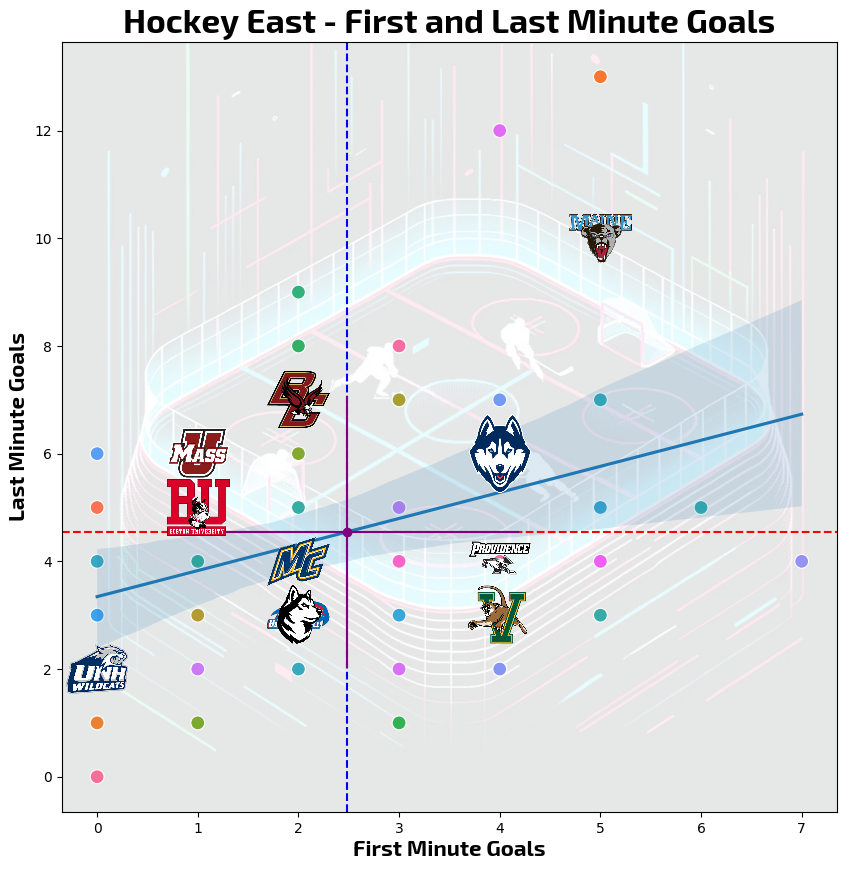

In [436]:
##Call the function
create_first_last_goal_plot_1(group_title, teams_to_plot)

#### PLOT: First and Last Minute Goals By Percentage

In [437]:
## By Goal Count

def create_first_last_goal_plot_1(group_title, teams_to_plot):
    # figure_size = set_fig_size # Unness

    # Calculate average and standard deviation for First Minute Goals and Last Minute Goals
    avg_first_minute = team_goal_tally['Pct First Minute'].mean()
    std_first_minute = team_goal_tally['Pct First Minute'].std()
    avg_last_minute = team_goal_tally['Pct Last Minute'].mean()
    std_last_minute = team_goal_tally['Pct Last Minute'].std()

    # Create the base scatter plot with all teams
    fig, ax = plt.subplots(figsize = set_fig_size)
    sns.scatterplot(data=team_goal_tally, x='Pct First Minute', y='Pct Last Minute', 
        hue='Team', s=100, ax=ax)
    

    # Add Trend Line
    sns.regplot(data=team_goal_tally, x='Pct First Minute', y='Pct Last Minute', 
        scatter=False, ax=ax)

    # Adjust x-axis to add padding on the left
    xmin, xmax = ax.get_xlim()
    new_xmin = xmin  # Subtract 2 from the x-minimum for additional padding
    ax.set_xlim(new_xmin, xmax)

    # Get and Adjust y-limits if needed
    ymin, ymax = ax.get_ylim()


    # Plot the average and standard deviation lines
    plt.axhline(y=avg_last_minute, color='red', linestyle='--', label='Average Pct Last Minute Goals')
    plt.axvline(x=avg_first_minute, color='blue', linestyle='--', label='Average Pct First Minute Goals')
    plt.errorbar(avg_first_minute, avg_last_minute, xerr=std_first_minute, 
        yerr=std_last_minute, fmt='o', color='purple', label='Standard Deviation')    

    # Set the background image (ensure the image is adjusted tot he new x and y limits)
    ax.imshow(bg_img, extent=[new_xmin, xmax, ymin, ymax], aspect='auto', zorder=0, alpha=alpha_value)

    # Add logos for specific teams (the teams_to_plot list)
    add_logos_to_plot(team_goal_tally, 'Pct First Minute', 'Pct Last Minute', logo_mapping, logo_folder, ax, teams_to_plot) # Add the logos

    # Remove the legend from the plot
    ax.get_legend().remove()

    # Add title and axis labels
    plt.title(f'{group_title} - First and Last Minute Goals\nBy Percentage of Total Goals', fontdict=font_title_param)
    plt.xlabel("First Minute Goals", fontdict=font_label_param)
    plt.ylabel('Last Minute Goals', fontdict=font_label_param)

    # Save plot to the temp output folder
    plot_path = os.path.join(output_folder, f'{group_title}_Pct_First_Last_Goals_1.png')
    plt.savefig(plot_path, bbox_inches='tight')

    # Show the plot
    plt.show()    
    

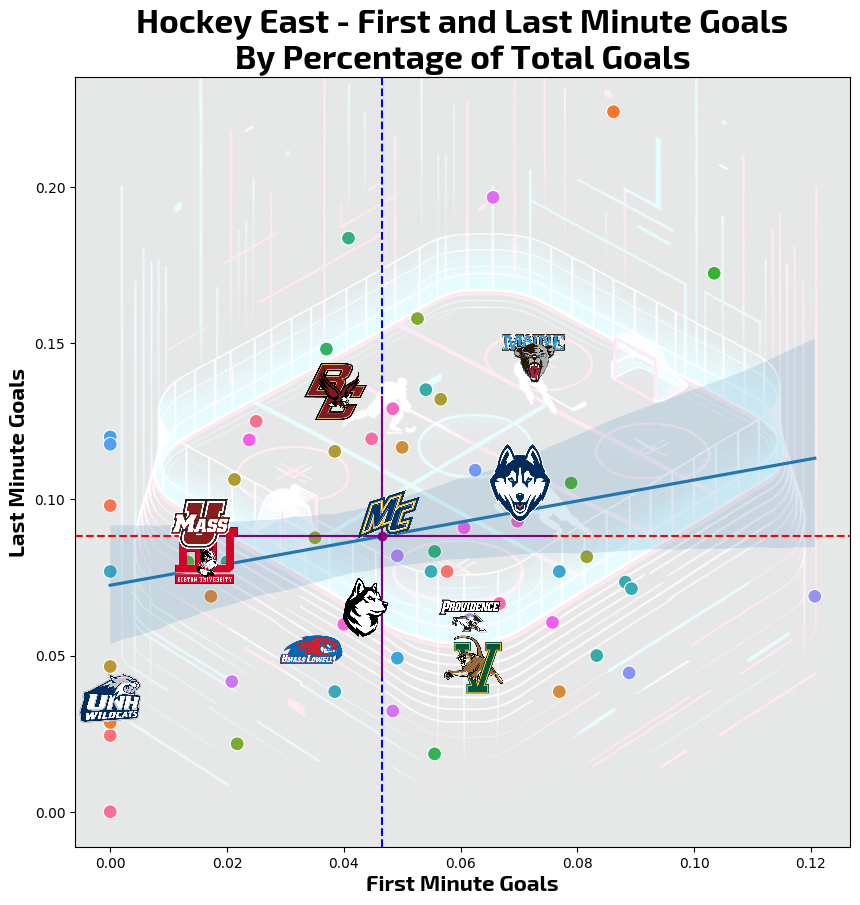

In [438]:
## Call the function
create_first_last_goal_plot_1(group_title, teams_to_plot)

#### PLOT: Last 2 Minute and First 2 Minute Goals

In [439]:
## By Goal Count

def create_first_last_goal_plot_2(group_title, teams_to_plot):
    # figure_size = set_fig_size # Unness

    # Calculate average and standard deviation for First Minute Goals and Last Minute Goals
    avg_first_minute = team_goal_tally['First 2 Minutes'].mean()
    std_first_minute = team_goal_tally['First 2 Minutes'].std()
    avg_last_minute = team_goal_tally['Last 2 Minutes'].mean()
    std_last_minute = team_goal_tally['Last 2 Minutes'].std()

    # Create the base scatter plot with all teams
    fig, ax = plt.subplots(figsize = set_fig_size)
    sns.scatterplot(data=team_goal_tally, x='First 2 Minutes', y='Last 2 Minutes', 
        hue='Team', s=100, ax=ax)
    

    # Add Trend Line
    sns.regplot(data=team_goal_tally, x='First 2 Minutes', y='Last 2 Minutes', 
        scatter=False, ax=ax)

    # Adjust x-axis to add padding on the left
    xmin, xmax = ax.get_xlim()
    new_xmin = xmin  # Subtract 2 from the x-minimum for additional padding
    ax.set_xlim(new_xmin, xmax)

    # Get and Adjust y-limits if needed
    ymin, ymax = ax.get_ylim()


    # Plot the average and standard deviation lines
    plt.axhline(y=avg_last_minute, color='red', linestyle='--', label='Average Last Minute Goals')
    plt.axvline(x=avg_first_minute, color='blue', linestyle='--', label='Average First Minute Goals')
    plt.errorbar(avg_first_minute, avg_last_minute, xerr=std_first_minute, 
        yerr=std_last_minute, fmt='o', color='purple', label='Standard Deviation')    

    # Set the background image (ensure the image is adjusted tot he new x and y limits)
    ax.imshow(bg_img, extent=[new_xmin, xmax, ymin, ymax], aspect='auto', zorder=0, alpha=alpha_value)

    # Add logos for specific teams (the teams_to_plot list)
    add_logos_to_plot(team_goal_tally, 'First 2 Minutes', 'Last 2 Minutes', logo_mapping, logo_folder, ax, teams_to_plot) # Add the logos

    # Remove the legend from the plot
    ax.get_legend().remove()

    # Add title and axis labels
    plt.title(f'{group_title} - Goals Scored in First and Last 2 Minutes', fontdict=font_title_param)
    plt.xlabel('First 2 Minute Goals', fontdict=font_label_param)
    plt.ylabel('Last 2 Minute Goals', fontdict=font_label_param)

    # Save plot to the temp output folder
    plot_path = os.path.join(output_folder, f'{group_title}_First_Last_Goals_2.png')
    plt.savefig(plot_path, bbox_inches='tight')

    # Show the plot
    plt.show()    
    

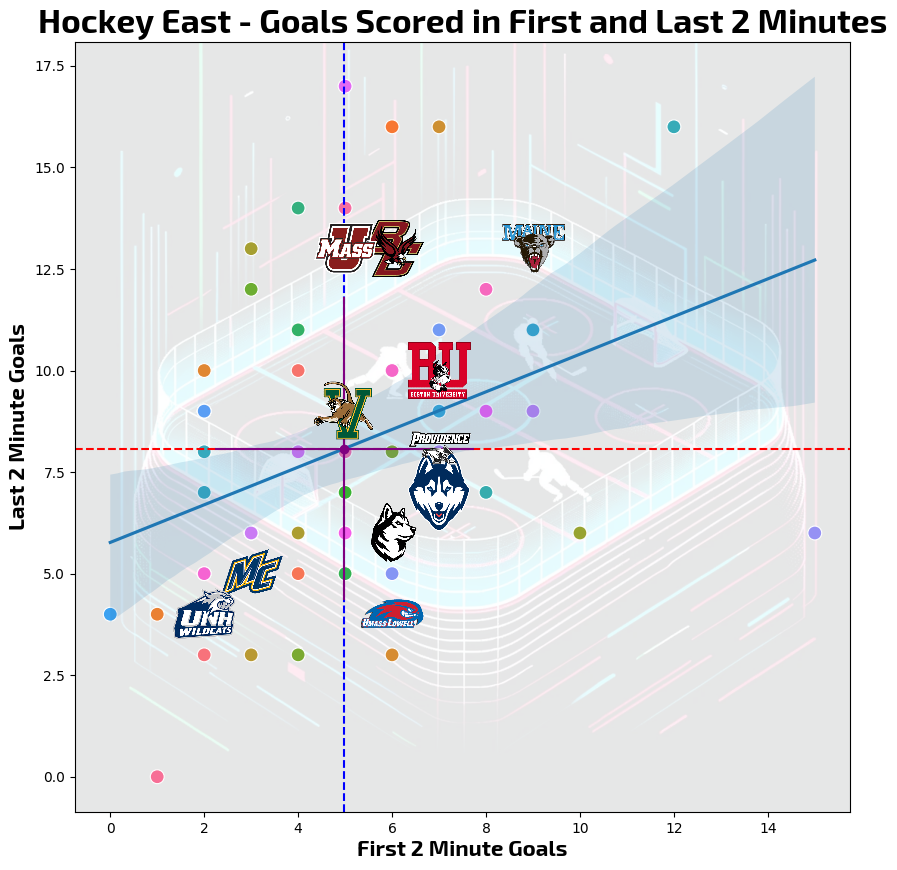

In [440]:
## Call the function
create_first_last_goal_plot_2(group_title, teams_to_plot)

### PLOT: Scored first and last 2 minutes by percentage

In [441]:
## By Goal Count

def create_first_last_goal_plot_percent_2(group_title, teams_to_plot):
    # figure_size = set_fig_size # Unness

    # Calculate average and standard deviation for First Minute Goals and Last Minute Goals
    avg_first_minute = team_goal_tally['Pct First 2 Minutes'].mean()
    std_first_minute = team_goal_tally['Pct First 2 Minutes'].std()
    avg_last_minute = team_goal_tally['Pct Last 2 Minutes'].mean()
    std_last_minute = team_goal_tally['Pct Last 2 Minutes'].std()

    # Create the base scatter plot with all teams
    fig, ax = plt.subplots(figsize = set_fig_size)
    sns.scatterplot(data=team_goal_tally, x='Pct First 2 Minutes', y='Pct Last 2 Minutes', 
        hue='Team', s=100, ax=ax)
    

    # Add Trend Line
    sns.regplot(data=team_goal_tally, x='Pct First 2 Minutes', y='Pct Last 2 Minutes', 
        scatter=False, ax=ax)

    # Adjust x-axis to add padding on the left
    xmin, xmax = ax.get_xlim()
    new_xmin = xmin  # Subtract 2 from the x-minimum for additional padding
    ax.set_xlim(new_xmin, xmax)

    # Get and Adjust y-limits if needed
    ymin, ymax = ax.get_ylim()


    # Plot the average and standard deviation lines
    plt.axhline(y=avg_last_minute, color='red', linestyle='--', label='Average Pct Last Minute Goals')
    plt.axvline(x=avg_first_minute, color='blue', linestyle='--', label='Average Pct First Minute Goals')
    plt.errorbar(avg_first_minute, avg_last_minute, xerr=std_first_minute, 
        yerr=std_last_minute, fmt='o', color='purple', label='Standard Deviation')    

    # Set the background image (ensure the image is adjusted tot he new x and y limits)
    ax.imshow(bg_img, extent=[new_xmin, xmax, ymin, ymax], aspect='auto', zorder=0, alpha=alpha_value)

    # Add logos for specific teams (the teams_to_plot list)
    add_logos_to_plot(team_goal_tally, 'Pct First 2 Minutes', 'Pct Last 2 Minutes', logo_mapping, logo_folder, ax, teams_to_plot) # Add the logos

    # Remove the legend from the plot
    ax.get_legend().remove()

    # Add title and axis labels
    plt.title(f'{group_title} - Goals: First and Last 2 Minutes\nBy Percentage of Total Goals', fontdict=font_title_param)
    plt.xlabel('First 2 Minute Goals', fontdict=font_label_param)
    plt.ylabel('Last 2 Minute Goals', fontdict=font_label_param)

    # Save plot to the temp output folder
    plot_path = os.path.join(output_folder, f'{group_title}_Pct_First_Last_Goals_2.png')
    plt.savefig(plot_path, bbox_inches='tight')

    # Show the plot
    plt.show()    
    

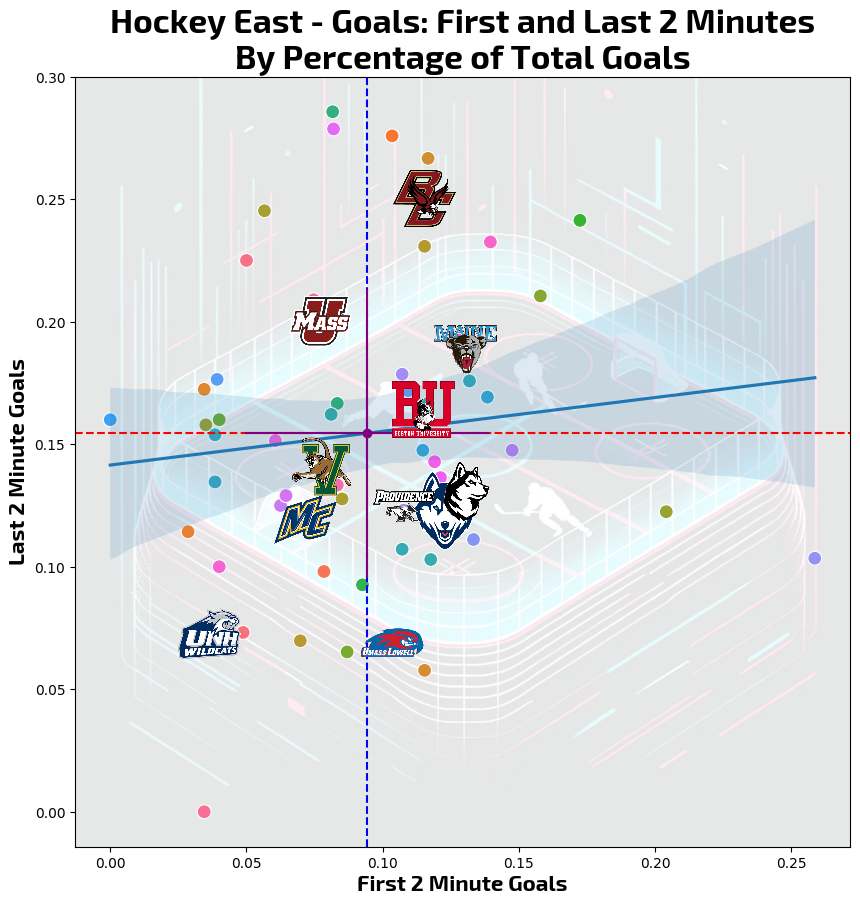

In [442]:
## Call the function
create_first_last_goal_plot_percent_2(group_title, teams_to_plot)

#### PLOT: High Impact Goals

In [443]:
## By Goal Count

def create_high_impact_plot_1(group_title, teams_to_plot):
    # figure_size = set_fig_size # Unness

    # Calculate average and standard deviation for First Minute Goals and Last Minute Goals
    avg_first_minute = team_goal_tally['HI_Back_to_Back'].mean()
    std_first_minute = team_goal_tally['HI_Back_to_Back'].std()
    avg_last_minute = team_goal_tally['HI_Quick_Response'].mean()
    std_last_minute = team_goal_tally['HI_Quick_Response'].std()

    # Create the base scatter plot with all teams
    fig, ax = plt.subplots(figsize = set_fig_size)
    sns.scatterplot(data=team_goal_tally, x='HI_Quick_Response', y='HI_Back_to_Back', 
        hue='Team', s=100, ax=ax)
    

    # Add Trend Line
    sns.regplot(data=team_goal_tally, x='HI_Quick_Response', y='HI_Back_to_Back', 
        scatter=False, ax=ax)

    # Adjust x-axis to add padding on the left
    xmin, xmax = ax.get_xlim()
    new_xmin = xmin  # Subtract 2 from the x-minimum for additional padding
    ax.set_xlim(new_xmin, xmax)

    # Get and Adjust y-limits if needed
    ymin, ymax = ax.get_ylim()


    # Plot the average and standard deviation lines
    plt.axhline(y=avg_last_minute, color='red', linestyle='--', label='Back to Back Goals')
    plt.axvline(x=avg_first_minute, color='blue', linestyle='--', label='Quick Response Goals')
    plt.errorbar(avg_first_minute, avg_last_minute, xerr=std_first_minute, 
        yerr=std_last_minute, fmt='o', color='purple', label='Standard Deviation')    

    # Set the background image (ensure the image is adjusted tot he new x and y limits)
    ax.imshow(bg_img, extent=[new_xmin, xmax, ymin, ymax], aspect='auto', zorder=0, alpha=alpha_value)

    # Add logos for specific teams (the teams_to_plot list)
    add_logos_to_plot(team_goal_tally, 'HI_Quick_Response', 'HI_Back_to_Back', logo_mapping, logo_folder, ax, teams_to_plot) # Add the logos

    # Remove the legend from the plot
    ax.get_legend().remove()

    # Add title and axis labels
    plt.title(f'{group_title} - High Impact Goals', fontdict=font_title_param)
    plt.xlabel('Quick Back To Back Goals', fontdict=font_label_param)
    plt.ylabel('Quick Response Goals', fontdict=font_label_param)

    # Save plot to the temp output folder
    plot_path = os.path.join(output_folder, f'{group_title}_High_Impact_1.png')
    plt.savefig(plot_path, bbox_inches='tight')

    # Show the plot
    plt.show()    
    

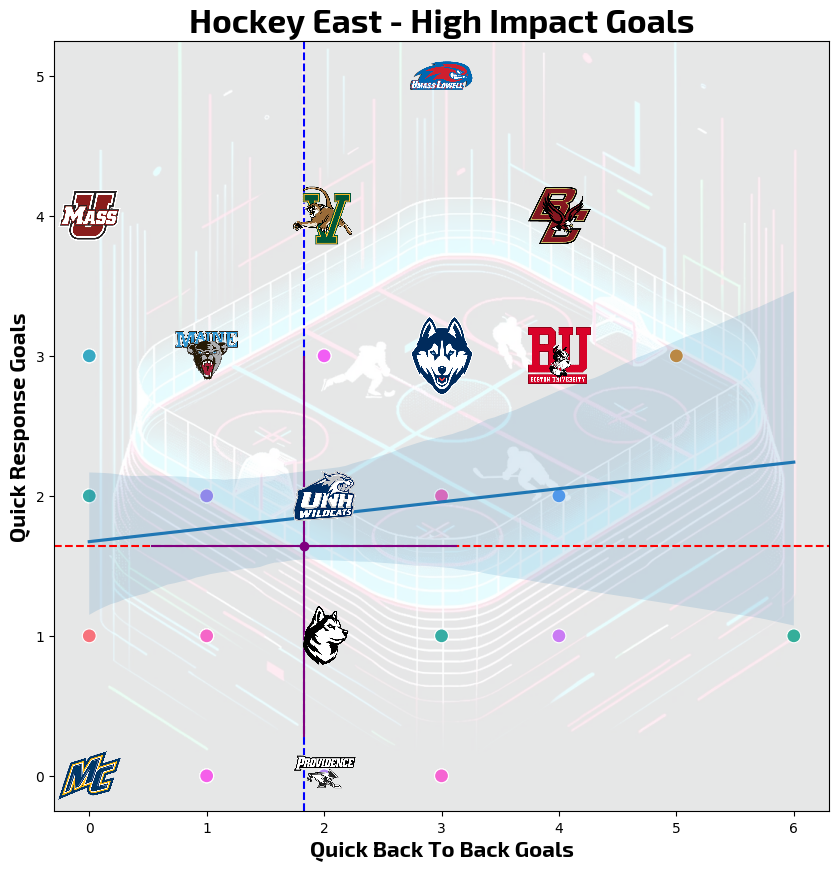

In [444]:
# Call the function
create_high_impact_plot_1(group_title, teams_to_plot)

#### PLOT: High Impact (2 minute) Goals

In [445]:
## By Goal Count

def create_high_impact_plot_2(group_title, teams_to_plot):
    # figure_size = set_fig_size # Unness

    # Calculate average and standard deviation for First Minute Goals and Last Minute Goals
    avg_first_minute = team_goal_tally['HI_Back_to_Back_2'].mean()
    std_first_minute = team_goal_tally['HI_Back_to_Back_2'].std()
    avg_last_minute = team_goal_tally['HI_Quick_Response_2'].mean()
    std_last_minute = team_goal_tally['HI_Quick_Response_2'].std()

    # Create the base scatter plot with all teams
    fig, ax = plt.subplots(figsize = set_fig_size)
    sns.scatterplot(data=team_goal_tally, x='HI_Quick_Response_2', y='HI_Back_to_Back_2', 
        hue='Team', s=100, ax=ax)
    

    # Add Trend Line
    sns.regplot(data=team_goal_tally, x='HI_Quick_Response_2', y='HI_Back_to_Back_2', 
        scatter=False, ax=ax)

    # Adjust x-axis to add padding on the left
    xmin, xmax = ax.get_xlim()
    new_xmin = xmin  # Subtract 2 from the x-minimum for additional padding
    ax.set_xlim(new_xmin, xmax)

    # Get and Adjust y-limits if needed
    ymin, ymax = ax.get_ylim()


    # Plot the average and standard deviation lines
    plt.axhline(y=avg_last_minute, color='red', linestyle='--', label='Back to Back Goals')
    plt.axvline(x=avg_first_minute, color='blue', linestyle='--', label='Quick Response Goals')
    plt.errorbar(avg_first_minute, avg_last_minute, xerr=std_first_minute, 
        yerr=std_last_minute, fmt='o', color='purple', label='Standard Deviation')    

    # Set the background image (ensure the image is adjusted tot he new x and y limits)
    ax.imshow(bg_img, extent=[new_xmin, xmax, ymin, ymax], aspect='auto', zorder=0, alpha=alpha_value)

    # Add logos for specific teams (the teams_to_plot list)
    add_logos_to_plot(team_goal_tally, 'HI_Quick_Response_2', 'HI_Back_to_Back_2', logo_mapping, logo_folder, ax, teams_to_plot) # Add the logos

    # Remove the legend from the plot
    ax.get_legend().remove()

    # Add title and axis labels
    plt.title(f'{group_title} - High Impact Goals (2 Minute Limit)', fontdict=font_title_param)
    plt.xlabel('Quick Back To Back Goals', fontdict=font_label_param)
    plt.ylabel('Quick Response Goals', fontdict=font_label_param)

    # Save plot to the temp output folder
    plot_path = os.path.join(output_folder, f'{group_title}_High_Impact_2.png')
    plt.savefig(plot_path, bbox_inches='tight')

    # Show the plot
    plt.show()    
    

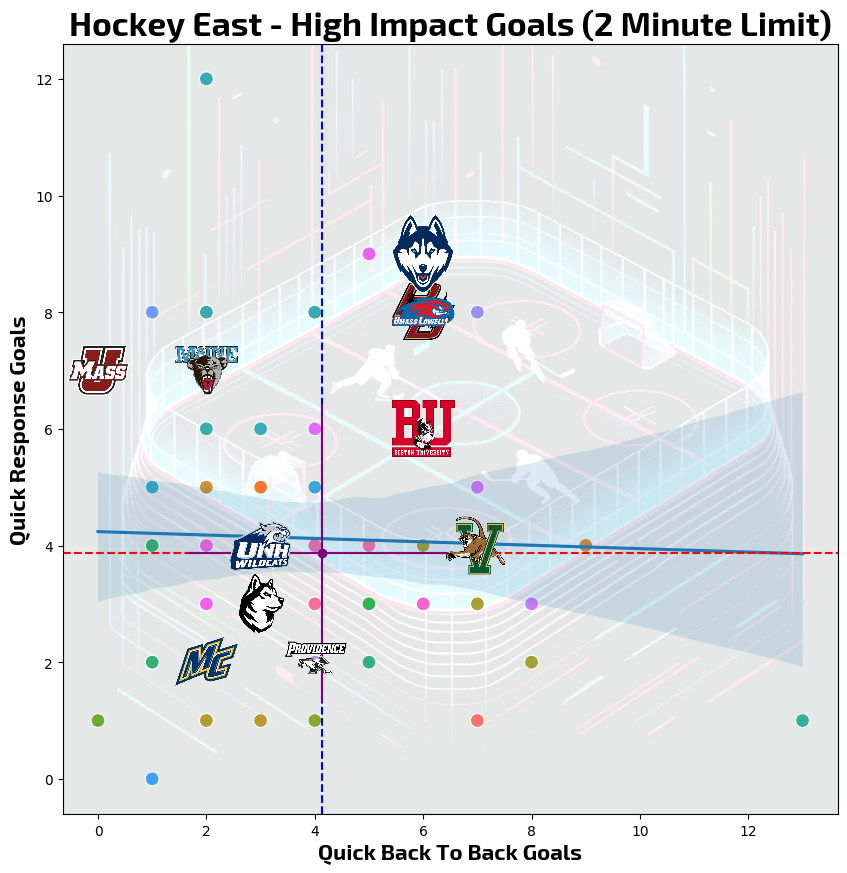

In [447]:
# Call the function
create_high_impact_plot_2(group_title, teams_to_plot)